<a href="https://colab.research.google.com/github/caalvaro/NumericalMethods/blob/main/Clusteriza%C3%A7%C3%A3o_Espectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho final para a disciplina de Métodos Numéricos 2.

Aluno: Álvaro de Carvalho Alves

# Por que usar a Clusterização Espectral?

Vamos usar um exemplo de dados e ver que o K-Means performa muito mal nele.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # cria um conjunto de clusters
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Resultado KMeans')

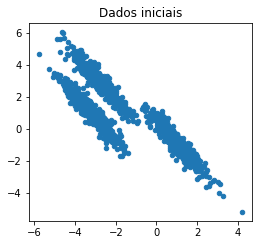

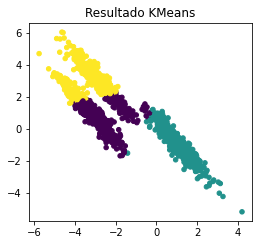

In [ ]:
n_samples = 1500 # tamanho do dataset
random_state = 170

# cria um dataset com nuvens de pontos
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# estica os dados para o exemplo ficar mais interessante
transformacao = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

# aplica a transformação nos dados
X = np.dot(X, transformacao)

# plot dos dados
plt.figure(figsize=(4,8))
plt.subplot(211)
plt.scatter(X[:,0], X[:,1], s=20)
plt.title("Dados iniciais")

# executa o K-Means nos dados
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

# plot dos resultados
plt.figure(figsize=(4,8))
plt.subplot(212)
plt.scatter(X[:,0], X[:,1], c=y_pred, s=20)
plt.title("Resultado KMeans")

O **K-Means** performa mal em dados que possuem determinadas características, pois usa a medida de **distância euclidiana** para determinar a similaridade entre os dados. Essa medida acaba não sendo eficiente quando os dados são circulares ou formam curvas. A **Clusterização Espectral** consegue lidar melhor com eles.



# Funcionamento da Clusterização Espectral

### A ideia geral

A ideia da **Clusterização Espectral** é visualizar os dados como um **Grafo**, onde cada dado é um vértice e as arestas possuem pesos que dizem o quão similar os dados são entre si.

Dessa forma, podemos definir uma função que determina a similaridade entre os dados e transformar o problema num problema de **partição de Grafos**.

### Função de Similaridade

Existem diversas possibilidades para definir a similaridade entre os dados. Cada uma será adequada para o problema em questão. 

Para este trabalho, definiremos uma matriz de similaridade $W$ entre dois dados da seguinte forma:

$$W_{i, j} = e^{-\gamma \lVert x_i - x_j \rVert^2}$$

Onde:

*   $\gamma$ é um parâmetro para o decaimento da função
*   $\lVert x_i - x_j \rVert^2$ é a distância entre o i-ésimo dado e o j-ésimo dado numa matriz de dados $X$

Dessa forma, daremos prioridade para os dados que têm menor distância entre si, pois a aresta que os liga terá um peso maior.


Usaremos a função *cdist* para criar uma matriz de similaridade $S$, definida como:

$$S_{i, j} = \lVert x_i - x_j \rVert^2$$

Isto é, cada posição da matriz será a distância entre o i-ésimo e o j-ésimo dado da matriz X.

In [ ]:
from scipy.spatial import distance

S = distance.cdist(X, X, metric='sqeuclidean')

Então, aplicaremos a função $e^{-\gamma x}$ em cada valor $x$ da matriz $S$, gerando a matriz de pesos $W$.

In [ ]:
gamma = 7.6
W = np.exp(- gamma * S)

Criamos então uma matriz $W$ que representa um grafo gerado a partir dos dados.

Com isso, o problema agora é particionar o grafo. Isso geralmente é feito minimizando o *cut* entre as partições. Isso é, se vamos particionar o grafo em duas partições $A$ e $B$, queremos minimizar:

$$cut(A,B) = \sum_{u \in A, v \in B} w(u,v)$$

Onde $w(u,v)$ é o peso entre os vértices $u$ e $v$.

Entretanto, essa técnica não é eficiente para clusterização, pois prioriza o particionamento de nós isolados que minimizam o $Cut$.

Dessa forma, a ideia apresentada por Jianbo Shi e Jitendra Malik é minimizar uma nova medida, chamada de *normalized cut* ($Ncut$):

$$Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)}+\frac{cut(A,B)}{assoc(B,V)}$$

Onde $assoc(A,V) = \sum_{u \in A, t \in V}w(u, t)$ é a soma dos pesos entre $A$ e todo o resto do grafo.



Eles mostraram, então, que esse problema se reduz a um **Problema de Autovalores Generalizados**:

$$(D-W)y = \lambda Dy$$

Onde $W$ é a matriz com os pesos das arestas e $D$ é a matriz cujos elementos da diagonal são a soma de cada linha em $W$.


Esse problema, por sua vez, usando $z = D^{\frac12}y$, pode ser reescrito como:

$$D^{-\frac12}(D-W)D^{-\frac12}z = \lambda z$$

Definimos então a Matriz Laplaciana Normalizada como:

$$L = D^{-\frac12}(D-W)D^{-\frac12}$$

Então, nosso problema se seguirá a partir dos autovalores da Laplaciana.

### Como fazer a clusterização a partir dos autovetores?

A Matriz Laplaciana possui muitas características interessantes que podemos explorar para entender melhor o grafo que ela representa. Abaixo, vemos uma análise de como os autovalores se comportam a medida que adicionamos arestas num grafo.

![photo_2020-09-12_19-37-11.jpg](https://miro.medium.com/max/700/1*p2vrLlFxdJgGZxCGO5WBmA.gif)
---
Imagem 1: Análise dos autovalores https://towardsdatascience.com/spectral-clustering-aba2640c0d5b [accessed 13 Oct, 2021]

É possível ver na animação acima que, a medida que a quantidade de arestas cresce, os autovalores crescem também.

**Propriedades da Laplaciana:** 

* A quantidade de **autovalores nulos** é a quantidade de **componentes conexas** do grafo.

* O **menor autovalor não nulo** mede o quão denso é o grafo, isso é o quanto os vértices estão conectados entre si. Se todos os vértices estivessem conectados, esse autovalor corresponderia à quantidade de vértices.

* Os outros autovalores correspondem a **quanto é necessário para particionar** o grafo. Por exemplo, o segundo menor autovalor não nulo mostra o quanto precisamos cortar para termos duas componentes conexas.


Podemos usar essas informações para analisar a quantidade de clusters que existem nos nossos dados, procurando pelo cotovelo da curva formada pelos autovalores da Laplaciana.


Uma forma similar de fazer essa análise é, em vez de usar a Laplaciana $L$, usar a matriz definida como:

$$M = I - L = D^{-\frac12}WD^{-\frac12}$$

Onde $I$ é a matriz identidade.

Dessa forma, em vez de usarmos os menores autovalores, usaremos os maiores.

Isso é útil pois evita ter que analisar numéricamente os autovalores, já que não precisamos evitar os autovalores nulos. Também facilita na indexação das matrizes, já que pegaremos os primeiros autovetores, não os últimos.

Com isso, podemos usar um resultado muito interessante para calcular os autovalores e os autovetores:

Temos que $M$ é uma Matriz Positiva Semi-Definida (os autovalores são maiores ou iguais a zero). Assim, teremos que **os autovalores serão iguais aos valores singulares.** Então podemos usar o SVD para calculá-los.

### Execução da Clusterização

Vamos criar a matriz $D$ que corresponde a soma dos pesos em $W$.

OBS: Como $D$ é uma matriz diagonal e, por consequência, muito esparsa, aqui a matriz D será um array unidimensional.

In [ ]:
D = W.sum(axis=1)

Geramos, então, $D^{-\frac12}$, que é nada mais que a inversa de $D$ com a raiz quadrada dos seus elementos.

In [ ]:
inv_sqrt_D = np.sqrt(1/D)

Criamos a matriz $M$ como definida anteriormente.

In [ ]:
# usamos a função np.multiply que faz multiplicação elemento por elemento para evitar lidar com a esparsidade de inv_sqrt_D
M = np.multiply(inv_sqrt_D[np.newaxis,:], np.multiply(W, inv_sqrt_D[:,np.newaxis]))

Calculamos o SVD da matriz $M$ para encontrar seus autovalores e autovetores.

Pegamos então os 3 primeiros autovetores após o segundo autovetor. 

In [ ]:
from scipy import linalg # biblioteca de álgebra linear do SciPy

U, Sigma, _ = linalg.svd(M, full_matrices=False)

In [ ]:
U_maiores = U[:, 0:3]
U_maiores

array([[ 2.67160289e-02, -9.89305678e-05, -1.50994871e-02],
       [ 2.27772379e-02, -8.43455440e-05, -1.28840541e-02],
       [ 1.54290936e-02, -5.72858501e-05, -1.34609904e-02],
       ...,
       [ 2.59416693e-02, -9.39952168e-05,  3.62418326e-02],
       [ 1.24892028e-02, -4.53600549e-05,  1.50712825e-02],
       [ 3.24769702e-02, -1.17686213e-04,  4.53180754e-02]])

Análise dos autovalores

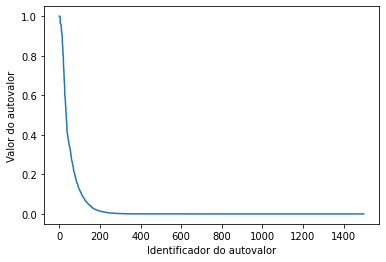

In [ ]:
plt.ylabel("Valor do autovalor")
plt.xlabel("Identificador do autovalor")
plt.plot(Sigma)

Usaremos os autovetores selecionados para clusterizar. Cada posição dos autovetores dirá em qual cluster o dado associado a ela está.

Para fazer essa análise, podemos usar o K-Means.

In [ ]:
from sklearn.preprocessing import normalize

y_pred_sc = KMeans(n_clusters=3, random_state=random_state).fit_predict(normalize(U_maiores))

Temos, então, o resultado final da Clusterização Espectral.

Text(0.5, 1.0, 'Resultado Clusterização Espectral')

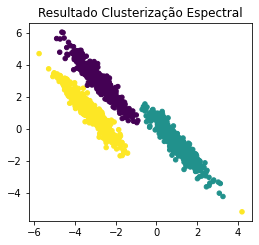

In [ ]:
plt.figure(figsize=(4,8))
plt.subplot(212)
plt.scatter(X[:,0], X[:,1], c=y_pred_sc, s=20)
plt.title("Resultado Clusterização Espectral")

### Teste com outro conjunto de dados

Text(0.5, 1.0, 'Resultado Clusterização Espectral')

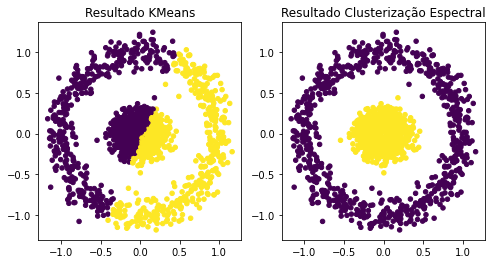

In [ ]:
from sklearn.datasets import make_circles

# criação dos dados
X,_ = make_circles(n_samples=1500, noise=0.1, factor=.2, random_state=random_state)

# parâmetro do kernel gaussiano
rbf_param = 7

# matriz de pesos
W = np.exp(-rbf_param * distance.cdist(X, X, metric='sqeuclidean'))

# matriz com os graus
D = W.sum(axis=1)
inv_sqrt_D = np.sqrt(1/D)

# matriz relacionada com a Laplaciana
M = np.multiply(inv_sqrt_D[np.newaxis,:], np.multiply(W, inv_sqrt_D[:,np.newaxis]))

# cálculo dos autovalores
U, Sigma, _ = linalg.svd(M, full_matrices=False)
U_maiores = U[:, 0:2]

# clusterização por K-Means padrão
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

# usando o K-Means para a clusterização espectral
y_pred_sc = KMeans(n_clusters=2, random_state=random_state).fit_predict(normalize(U_maiores))

# plot dos resultados
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y_pred, s=20)
plt.title("Resultado KMeans")

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], c=y_pred_sc, s=20)
plt.title("Resultado Clusterização Espectral")

# Referências



1.   Jianbo Shi and J. Malik, "Normalized cuts and image segmentation," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 22, no. 8, pp. 888-905, Aug. 2000, doi: 10.1109/34.868688.
2. Andrew Y. Ng, Michael I. Jordan, and Yair Weiss. 2001. On spectral clustering: analysis and an algorithm. In Proceedings of the 14th International Conference on Neural Information Processing Systems: Natural and Synthetic (NIPS'01). MIT Press, Cambridge, MA, USA, 849–856.
3.   Spectral Clustering: Foundation and Application (https://towardsdatascience.com/spectral-clustering-aba2640c0d5b), acesso em 13 de outubro de 2021.
4. https://en.wikipedia.org/wiki/Spectral_clustering, acesso em 13 de outubro de 2021.
5. https://en.wikipedia.org/wiki/Laplacian_matrix, acesso em 13 de outubro de 2021.
6. https://www.youtube.com/watch?v=YHz0PHcuJnk, acesso em 13 de outubro de 2021.

